1 - download and get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.15G/4.16G [00:54<00:00, 107MB/s] 
100% 4.16G/4.16G [00:54<00:00, 82.5MB/s]


In [ ]:
!unzip /content/brats20-dataset-training-validation.zip

Archive:  /content/brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.n

2 - Explore the data

In [ ]:
#1 - the data is multimodal scans which means that it has 5 channels of 
# information which are t1 , t1ce , t2 , flair and then the label image
# segmented one which is the last one or mask
# 2 - in the data there are 5 labels : 0 means that it is unlabeled
# 1,2,4 it means alot but 3 is missing in this data so that means we have 
# just 4 color in the segmented image

In [ ]:
import pandas as pd
import cv2 
import PIL 
import numpy as np
import os
import glob 
from tensorflow.keras.utils import to_categorical
from tifffile import imsave
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
validation_path ='/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
train_path ='/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

In [ ]:
validation_paths =[]
for folder in os.listdir(validation_path): 
   validation_paths.append(folder)
train_paths =[]
for folder in os.listdir(train_path): 
   train_paths.append(folder)
print('num_of_trainimages',len(train_paths))
print('num_of_validationimages',len(validation_paths))

num_of_trainimages 371
num_of_validationimages 127


In [ ]:
image_falir = nib.load(train_path +'/'+ train_paths[0]+'/'+train_paths[0]+'_flair.nii').get_fdata()

In [ ]:
print(image_falir.shape)
print(image_falir.max())

(240, 240, 155)
1877.0


3 - get data ready

In [ ]:
# so as we see that the max value is very big so we need to scale the images
scaler = MinMaxScaler()

In [ ]:
# we should when we scale the image that we convert it to 1d then scale then return to 3d volume
image_falir = scaler.fit_transform(image_falir.reshape(-1 , image_falir.shape[-1])).reshape(image_falir.shape)

In [ ]:
image_t1 = nib.load(train_path +'/'+ train_paths[0]+'/'+train_paths[0]+'_t1.nii').get_fdata()
image_t1 = scaler.fit_transform(image_t1.reshape(-1 , image_t1.shape[-1])).reshape(image_t1.shape)
image_t2 = nib.load(train_path +'/'+ train_paths[0]+'/'+train_paths[0]+'_t2.nii').get_fdata()
image_t2 = scaler.fit_transform(image_t2.reshape(-1 , image_t2.shape[-1])).reshape(image_t2.shape)
image_t1ce = nib.load(train_path +'/'+ train_paths[0]+'/'+train_paths[0]+'_t1ce.nii').get_fdata()
image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1 , image_t1ce.shape[-1])).reshape(image_t1ce.shape)

In [ ]:
image_mask = nib.load(train_path +'/'+ train_paths[0]+'/'+train_paths[0]+'_seg.nii').get_fdata()
print(np.unique(image_mask))

[0. 1. 2. 4.]


In [ ]:
# because there is no 3 label we convert 4 label to 3
image_mask[image_mask ==4] = 3
print(np.unique(image_mask))

[0. 1.]


Text(0.5, 1.0, 'mask')

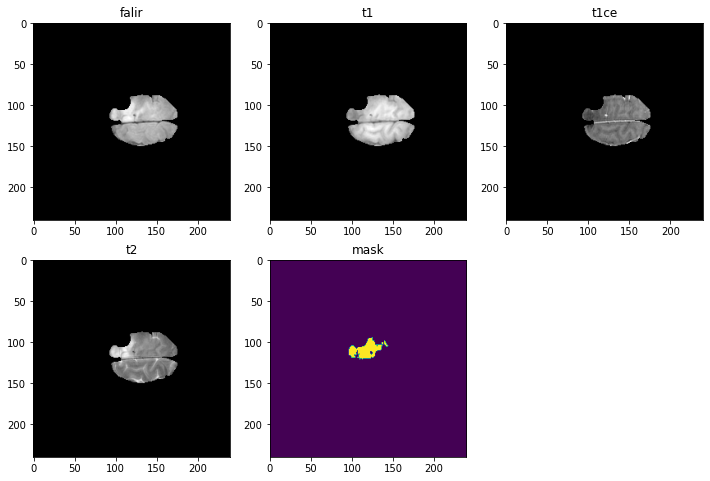

In [ ]:
# we will plot random slice in the 4 channels
import random 
n_slice = random.randint(0 , image_t1.shape[2])
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(image_falir[:,:,n_slice] , cmap='gray')
plt.title('falir')

plt.subplot(232)
plt.imshow(image_t1[:,:,n_slice] , cmap='gray')
plt.title('t1')

plt.subplot(233)
plt.imshow(image_t1ce[:,:,n_slice] , cmap='gray')
plt.title('t1ce')

plt.subplot(234)
plt.imshow(image_t2[:,:,n_slice] , cmap='gray')
plt.title('t2')

plt.subplot(235)
plt.imshow(image_mask[:,:,n_slice] )
plt.title('mask')

In [ ]:
# the model later will get just on channel so we need to choose one channel to feed into the model
# but instead we will combine t2,t1ce and flair into one channel so we can feed reach info to model
# t1 is not important so we discard it
combined = np.stack([image_falir , image_t1ce , image_t2] ,axis = 3)
print(combined.shape)

(240, 240, 155, 3)


In [ ]:
# because of there are alot of pixels around the target are dark so we will crop the image
combined = combined[56:184 ,56:184 , 13:141 ]
print(combined.shape)
image_mask = image_mask[56:184 ,56:184 , 13:141 ]
print(image_mask.shape)

(128, 128, 128, 3)
(128, 128, 128)


In [ ]:
# now after that we need to save the combined image to save the changes
np.save('/content/BraTS2020_TrainingData/combined001.npy' , combined)

In [ ]:
# we should convert mask image to categorical 
image_mask = to_categorical(image_mask , num_classes=4)
print(image_mask.shape)

(128, 128, 128, 4)


In [ ]:
# so we will do this changes to all the images in the trainset
t2_list = sorted(glob.glob('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
falir_list = sorted(glob.glob('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(t2_list)):
  temp_t2 = nib.load(t2_list[img]).get_fdata()
  temp_t2 = scaler.fit_transform(temp_t2.reshape(-1 , temp_t2.shape[-1])).reshape(temp_t2.shape)
  temp_t1ce = nib.load(t1ce_list[img]).get_fdata()
  temp_t1ce = scaler.fit_transform(temp_t1ce.reshape(-1 , temp_t1ce.shape[-1])).reshape(temp_t1ce.shape)
  temp_falir = nib.load(falir_list[img]).get_fdata()
  temp_falir = scaler.fit_transform(temp_falir.reshape(-1 , temp_falir.shape[-1])).reshape(temp_falir.shape)
  temp_mask = nib.load(mask_list[img]).get_fdata()
  temp_mask[temp_mask ==4] = 3


  temp_combined = np.stack([temp_falir , temp_t1ce , temp_t2] , axis = 3)

  temp_combined = temp_combined[56:184 ,56:184 , 13:141 ]
  temp_mask = temp_mask[56:184 ,56:184 , 13:141 ]
  
  val , counts = np.unique(temp_mask , return_counts=True)
  if ( 1 - (counts[0] / counts.sum())) > 0.01 :
    temp_mask = to_categorical(temp_mask , num_classes=4)
    np.save('/content/BraTS2020_TrainingData/images/image_' +str(img) +'.npy' , temp_combined)
    np.save('/content/BraTS2020_TrainingData/masks/mask_' +str(img) +'.npy' , temp_mask)
    

In [ ]:
# we should delete the old folder 
import shutil

shutil.rmtree('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')

In [ ]:
# we will split the data into train and test split by creating output and input folders

In [ ]:
!pip install split-folders
import splitfolders
input_folder = '/content/BraTS2020_TrainingData/input/'
output_folder = '/content/BraTS2020_TrainingData/output/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 688 files [03:40,  3.12 files/s]


In [ ]:
shutil.rmtree('/content/BraTS2020_TrainingData/input')

4 - building data generator

In [ ]:
# because of big of data are , so we cant use all data to feed the model 
# we need to load mini batches like 16 images at time to the model
# we cant use keras data generator because we are dealing with npy files

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [ ]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
train_img_dir = "/content/content/BraTS2020_TrainingData/output/train/images/"
train_mask_dir = "/content/content/BraTS2020_TrainingData/output/train/masks/"
train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

In [ ]:
img , msk = train_img_datagen.__next__()

In [ ]:
print(img.shape)
print(msk.shape)

(2, 128, 128, 128, 3)
(2, 128, 128, 128, 4)


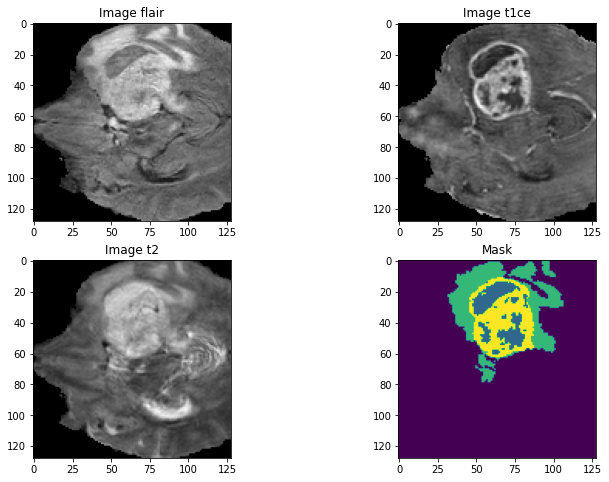

In [ ]:
import random
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

5 - building a model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.metrics import MeanIoU
from tensorflow import keras
kernel_initializer =  'he_uniform'

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [ ]:
train_img_dir = "/content/content/BraTS2020_TrainingData/output/train/images/"
train_mask_dir = "/content/content/BraTS2020_TrainingData/output/train/masks/"

val_img_dir = "/content/content/BraTS2020_TrainingData/output/val/images/"
val_mask_dir = "/content/content/BraTS2020_TrainingData/output/val/masks/"

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
! pip install segmentation_models_3D
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
Segmentation Models: using `tf.keras` framework.


In [ ]:
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
model.save('brats_3d.hdf5')

Epoch 1/100
 41/129 [========>.....................] - ETA: 1:32 - loss: 0.9837 - accuracy: 0.7337 - iou_score: 0.1208

KeyboardInterrupt: ignored

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

#Load model for  continue training
my_model = load_model('******.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
# Load model for prediction 
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      compile=False)

In [ ]:
# to try to predict some images and then look at accuracy
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
img_num = 82

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()